In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import scipy.stats as stats

import statsmodels.stats.multitest as multi

from sklearn.decomposition import PCA
from itertools import permutations, product, combinations
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from scipy.io import loadmat

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
folder = "Code/Matlab"

# Additional settings

In [4]:
dataset_labels = {'NHBE':'HBE', 'LUNG':'Lung', 'T':'293T', 'CALU':'Calu-3', 'A549':'A549'}

order = {'infection': ['healthy', 'infected'],
         'dataset': ['HBE', 'Lung', '293T', 'Calu-3', 'A549']}

In [5]:
data_files = [os.path.splitext(name)[0] for name in os.listdir(folder) if name.endswith('mat')]

In [6]:
data_files

['A549_Healthy_mean',
 'A549_Infected_mean',
 'CALU_Healthy_mean',
 'CALU_Infected_mean',
 'Lung_Healthy_mean',
 'Lung_Infected_mean',
 'NHBE_Healthy_mean',
 'NHBE_Infected_mean',
 'T_Healthy_mean',
 'T_Infected_mean']

In [7]:
len(data_files)

10

In [8]:
datasets = list(set([f.split("_")[0] for f in data_files]))
infections = list(set([f.split("_")[1] for f in data_files]))

In [9]:
datasets

['A549', 'T', 'NHBE', 'Lung', 'CALU']

In [10]:
infections

['Infected', 'Healthy']

In [11]:
infections = {}
datasets = {}

files_infections = {}
files_datasets = {}

for i,f in enumerate(data_files):
    dataset = f.split("_")[0]
    dataset = dataset_labels[dataset.upper()]
                   
    infection = f.split("_")[1]
    infection = 'healthy' if infection == 'Healthy' else 'infected'
    
    if infection not in infections:
        infections[infection] = []
    if dataset not in datasets:
        datasets[dataset] = []
               
    infections[infection].append(f)
    datasets[dataset].append(f)  
        
    files_infections[f] = infection
    files_datasets[f] = dataset



In [12]:
groups = {"infection": infections, "dataset": datasets}

In [13]:
files_infections

{'A549_Healthy_mean': 'healthy',
 'A549_Infected_mean': 'infected',
 'CALU_Healthy_mean': 'healthy',
 'CALU_Infected_mean': 'infected',
 'Lung_Healthy_mean': 'healthy',
 'Lung_Infected_mean': 'infected',
 'NHBE_Healthy_mean': 'healthy',
 'NHBE_Infected_mean': 'infected',
 'T_Healthy_mean': 'healthy',
 'T_Infected_mean': 'infected'}

# Model import and preprocessing

In [14]:
#file_names = [file_name for file_name in os.listdir(folder) if file_name.endswith('csv')]

In [15]:
df = pd.DataFrame(columns=data_files)

for f in data_files:
    t = loadmat(os.path.join(folder,f'{f}.mat'))
    m = t[f].astype(float)  
    m[m==-1] = np.nan
    
    df[f] = m.flatten()
    
    print(f'{f}:{m[m!=0].shape[0]}/{m.shape[0]}; missing {m[m==0].shape[0]} genes')
    
df = df.fillna(0)

A549_Healthy_mean:3387/3625; missing 238 genes
A549_Infected_mean:3409/3625; missing 216 genes
CALU_Healthy_mean:3414/3625; missing 211 genes
CALU_Infected_mean:3421/3625; missing 204 genes
Lung_Healthy_mean:3518/3625; missing 107 genes
Lung_Infected_mean:2494/3625; missing 1131 genes
NHBE_Healthy_mean:3360/3625; missing 265 genes
NHBE_Infected_mean:3370/3625; missing 255 genes
T_Healthy_mean:3347/3625; missing 278 genes
T_Infected_mean:3360/3625; missing 265 genes


In [16]:
df.head()

,A549_Healthy_mean,A549_Infected_mean,CALU_Healthy_mean,CALU_Infected_mean,Lung_Healthy_mean,Lung_Infected_mean,NHBE_Healthy_mean,NHBE_Infected_mean,T_Healthy_mean,T_Infected_mean
0,61.409914,69.080277,116.277983,119.457355,46.139842,6.954333,66.039087,57.549820,86.446268,92.012819
1,0.000000,0.035317,0.000000,0.012096,38.788173,430.698370,0.071729,0.094904,0.000000,0.000000
2,46.854748,45.177975,42.907891,26.128591,15.838985,6.524210,23.400222,22.284725,48.625804,39.619417
3,134.905287,125.547454,19.920375,20.327953,3.835999,2.119917,146.468255,109.037748,43.484077,39.832963
4,73.182231,81.836277,44.786324,23.966473,11.765404,26.192000,66.883642,66.451842,81.795080,63.541433


In [17]:
M = np.transpose(df.values)
M = M[:,~np.all(M==0, axis=0)]
#M = M[:,~np.any(M==0, axis=0)]
print(M.shape)
M = StandardScaler(with_mean=True, with_std=False).fit_transform(M) #centering only

(10, 3592)


# PCA

In [18]:
n_components = 2

In [19]:
pca = PCA(n_components=n_components)
comps = pca.fit_transform(M)
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2'])
df['data'] = data_files

In [20]:
df_pca = pd.DataFrame()
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_).T)
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_ratio_).T)
df_pca.columns = ['PC1', 'PC2']
df_pca['label'] = ['explained variance', 'explained variance ratio']
df_pca = df_pca.set_index('label')
df_pca.to_csv("results_PCA_data\\"+"explained_variance.csv")

In [21]:
df_pca

,PC1,PC2
label,,
explained variance,6.567187e+08,1.289588e+08
explained variance ratio,6.842919e-01,1.343733e-01


In [22]:
df_pca

,PC1,PC2
label,,
explained variance,6.567187e+08,1.289588e+08
explained variance ratio,6.842919e-01,1.343733e-01


In [23]:
pca_explained = pca.explained_variance_ratio_
pca_explained

array([0.68429195, 0.13437334])

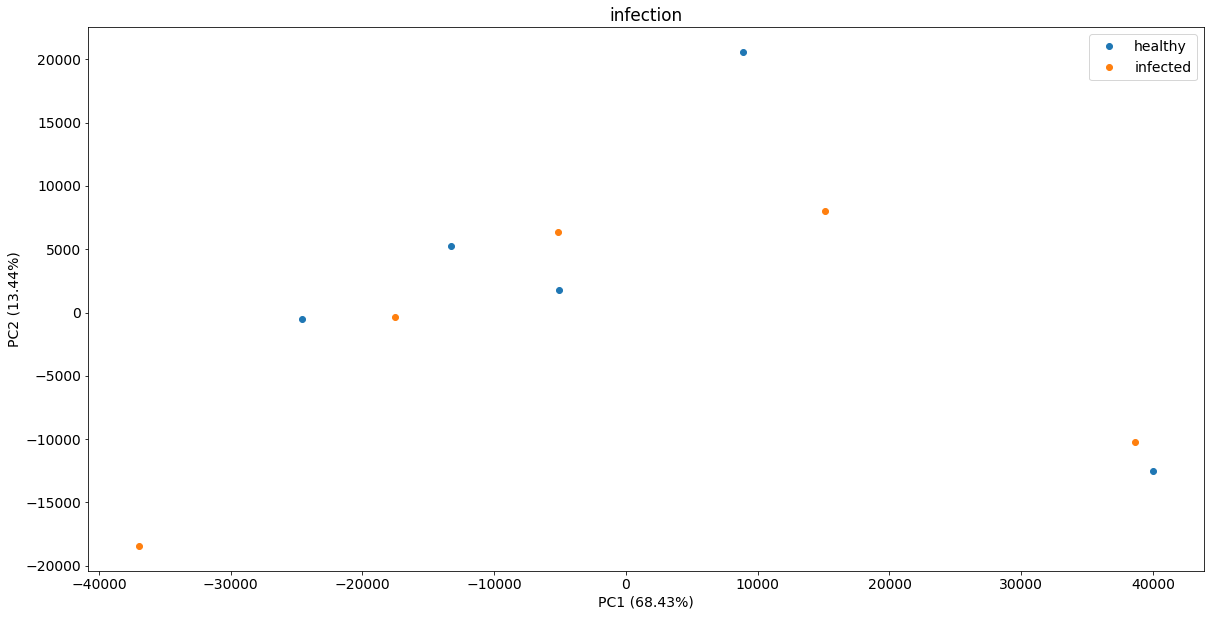

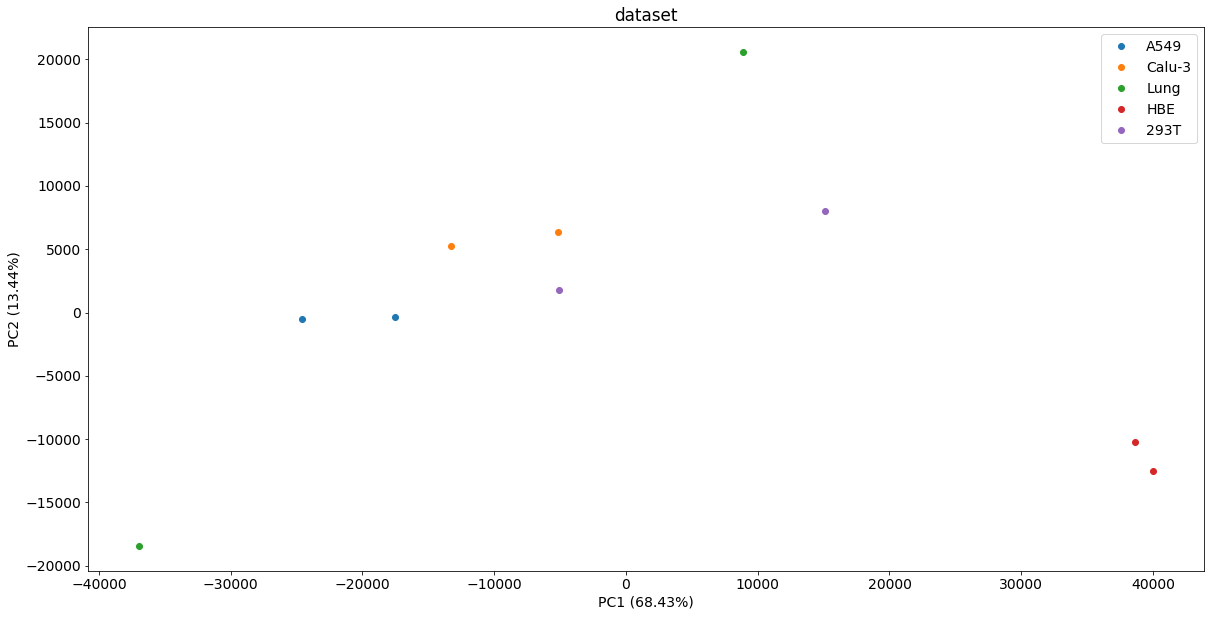

In [24]:
#print(data_files)

for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]

    for factor in groups:
        for group, data_group in groups[factor].items():                          
            locs = np.isin(data_files, data_group)
            #print(group,data_group, locs)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=group)
            
     
        plt.title(factor)
        
        plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("results_PCA_data\\PCA_PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".pdf", format="pdf", bbox_inches = 'tight')
        #plt.savefig("results_PCA\\PCA_"+label_MEM+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".png", format="png", bbox_inches = 'tight')
        plt.show()
        

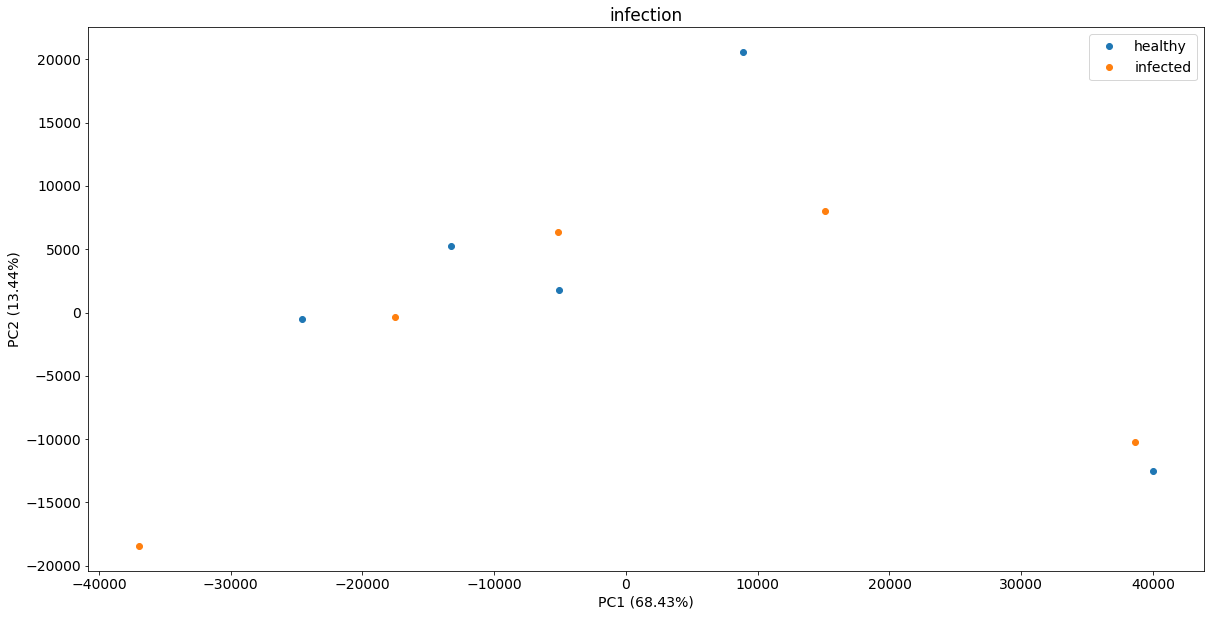

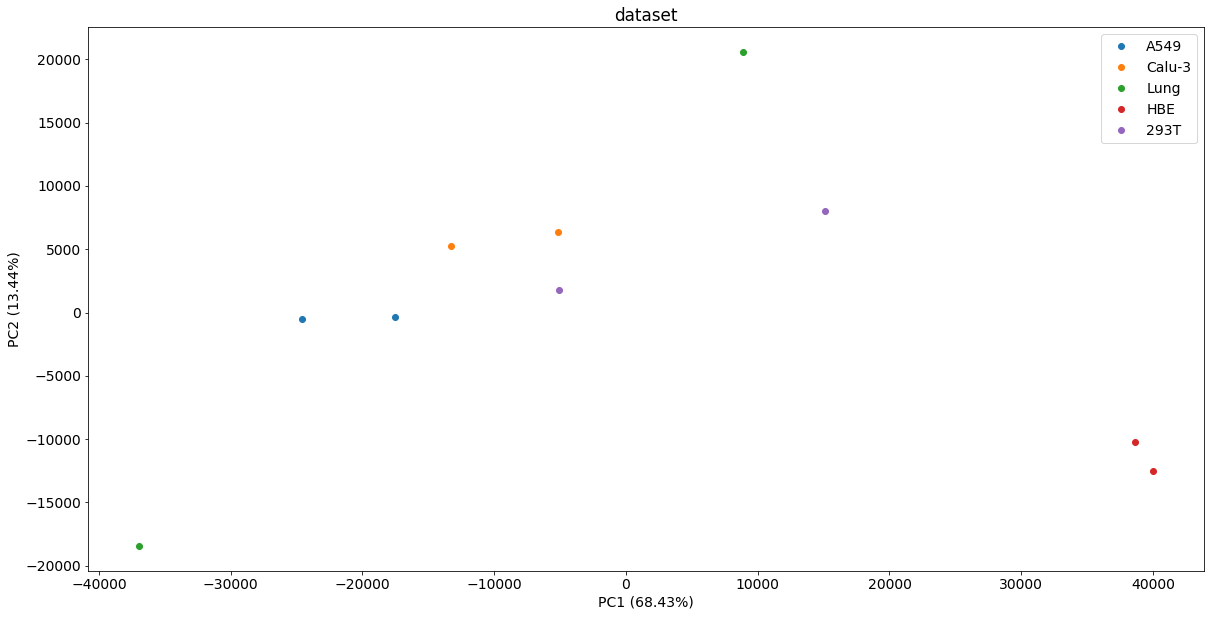

In [25]:
#print(data_files)

for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]

    for factor in groups:
        for group, data_group in groups[factor].items():                          
            locs = np.isin(data_files, data_group)
            #print(group,data_group, locs)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=group)
            
     
        plt.title(factor)
        
        plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("results_PCA_data\\PCA_PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".pdf", format="pdf", bbox_inches = 'tight')
        #plt.savefig("results_PCA\\PCA_"+label_MEM+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".png", format="png", bbox_inches = 'tight')
        plt.show()
        

# Variance explanation

In [26]:
factors = list(groups.keys())
Rs = np.zeros((len(factors), 2))
rhos = np.zeros((len(factors), 2))


for ii, factor in enumerate(groups):
    scores1 = []
    scores2 = []
    #scores3 = []
    
    """for i in range(len(groups[factor])):
        idxs = np.array(np.where(np.isin(models, groups[factor][i])==True)).flatten()
        scores1.append(sorted(df.iloc[idxs, 0].values))
        scores2.append(sorted(df.iloc[idxs, 1].values))
        #scores3.append(sorted(df.iloc[idxs, 2].values))
    """
    for files_factor in groups[factor].values():
        idxs = np.array(np.where(np.isin(data_files, files_factor)==True)).flatten()
        scores1.append(sorted(df.iloc[idxs, 0].values))
        scores2.append(sorted(df.iloc[idxs, 1].values))
        #scores3.append(sorted(df.iloc[idxs, 2].values))
    
    for idx in permutations(range(len(scores1))):
        s1 = []
        s2 = []
        #s3 = []        
        for i in idx:
            s1 += scores1[i]
            s2 += scores2[i]
            #s3 += scores3[i]
            
        
        R_PC1 = pearsonr(np.arange(len(s1)), s1)[0]
        R_PC2 = pearsonr(np.arange(len(s2)), s2)[0]
        #R_PC3 = pearsonr(np.arange(len(s3)), s3)[0]

        rho_PC1 = spearmanr(np.arange(len(s1)), s1)[0]
        rho_PC2 = spearmanr(np.arange(len(s2)), s2)[0]
        #rho_PC3 = spearmanr(np.arange(len(s3)), s3)[0]

        Rs[ii, 0] = max(Rs[ii, 0], abs(R_PC1))
        Rs[ii, 1] = max(Rs[ii, 1], abs(R_PC2))
        #Rs[ii, 2] = max(Rs[ii, 2], abs(R_PC3))

        rhos[ii, 0] = max(rhos[ii, 0], abs(rho_PC1))
        rhos[ii, 1] = max(rhos[ii, 1], abs(rho_PC2))
        #rhos[ii, 2] = max(rhos[ii, 2], abs(rho_PC3))



In [27]:
groups

{'infection': {'healthy': ['A549_Healthy_mean',
   'CALU_Healthy_mean',
   'Lung_Healthy_mean',
   'NHBE_Healthy_mean',
   'T_Healthy_mean'],
  'infected': ['A549_Infected_mean',
   'CALU_Infected_mean',
   'Lung_Infected_mean',
   'NHBE_Infected_mean',
   'T_Infected_mean']},
 'dataset': {'A549': ['A549_Healthy_mean', 'A549_Infected_mean'],
  'Calu-3': ['CALU_Healthy_mean', 'CALU_Infected_mean'],
  'Lung': ['Lung_Healthy_mean', 'Lung_Infected_mean'],
  'HBE': ['NHBE_Healthy_mean', 'NHBE_Infected_mean'],
  '293T': ['T_Healthy_mean', 'T_Infected_mean']}}

In [28]:
Rs2 = Rs ** 2
#df_R2 = pd.DataFrame(data = Rs2, columns = ['R2(PC1)', 'R2(PC2)', 'R2(PC3)'])
df_R2 = pd.DataFrame(data = Rs2, columns = ['R2(PC1)', 'R2(PC2)'])
df_R2['factor'] = groups.keys()
df_R2=df_R2.set_index('factor')

In [29]:
df_R2

,R2(PC1),R2(PC2)
factor,,
infection,0.273564,0.479626
dataset,0.740139,0.349888


In [30]:
df_R2.to_csv("results_PCA_data\\"+"variability_explained.csv")

# t-SNE

In [31]:
perplexity = 5

In [32]:
tSNE = TSNE(n_components=n_components, perplexity = perplexity,  n_iter=5000)
comps = tSNE.fit_transform(M)
#df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2', 'PC3'][:n_components])
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2'][:n_components])
df['data'] = data_files

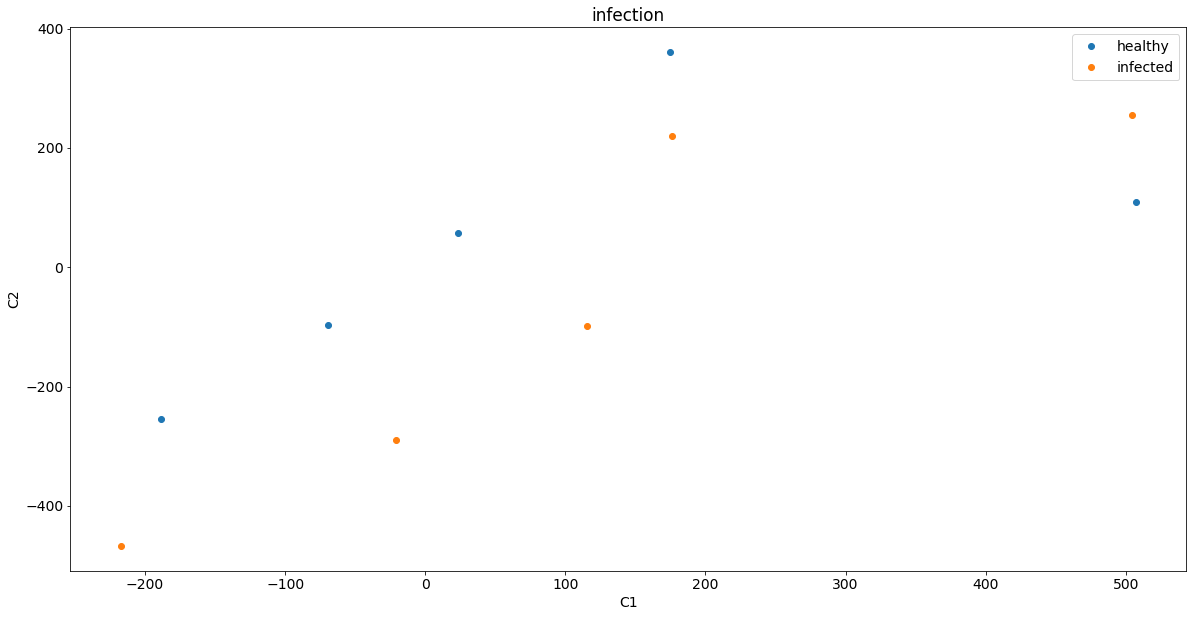

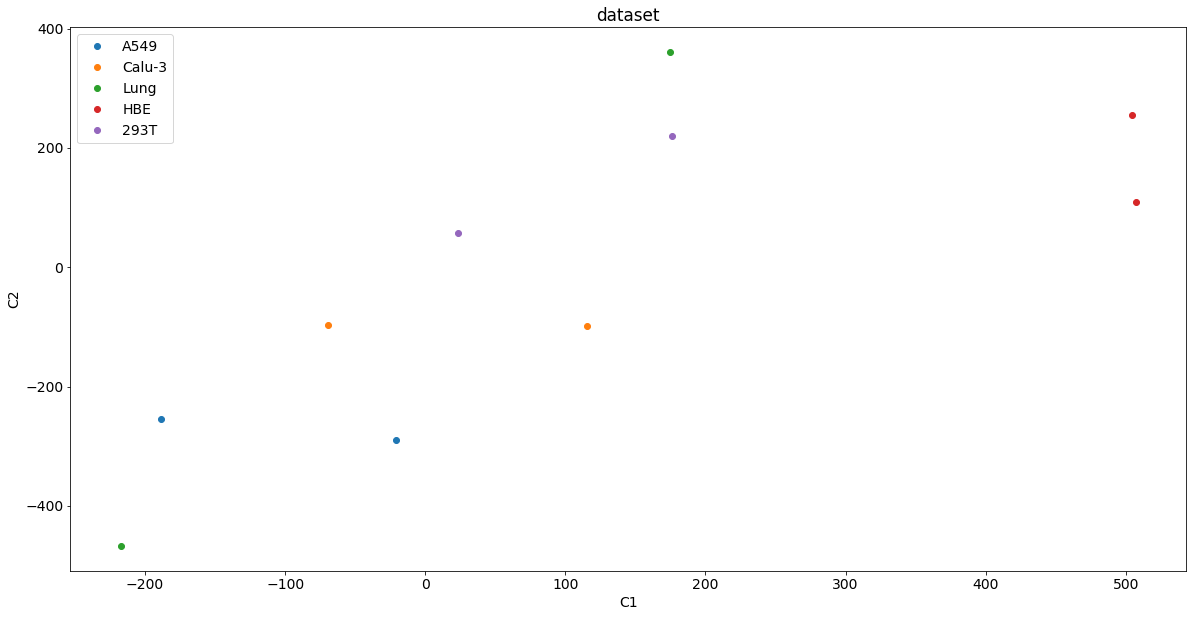

In [33]:
for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]
    for factor in groups:
        for group, data_group in groups[factor].items():                        
            locs = np.isin(data_files, data_group)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=group)
            
        #for model, x, y in zip(models, comps[:,i1], comps[:,i2]):        
        #    plt.text(x+0.05,y+0.05,model)

        plt.title(factor)
       
        plt.xlabel("C"+str(i1+1))#plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("C"+str(i2+1))#plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("results_PCA_data\\tSNE_C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+factor+".pdf", format="pdf", bbox_inches = 'tight')
        #plt.savefig("results_PCA\\tSNE_"+label_MEM+"C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+factor+".png", format="png", bbox_inches = 'tight')
        plt.show()